Including Scibert predictions instead of just keyword labeled data

In [69]:
# Imports

import pandas as pd
from pathlib import Path
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [70]:
# Paths

processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "total_results"

ml_methods_path = processed_abstracts_path / "regex_scispacy/abstracts_with_ml_methods_regex.csv"
ml_category_path = processed_abstracts_path / "scibert_tuned/abstracts_with_predictions_copy.csv"
production_category_path = processed_abstracts_path / "umap_kmean_tuned/abstracts_with_clusters.csv"
prod_cluster_keywords_path = processed_abstracts_path / "umap_kmean_tuned/cluster_keywords.json"

# Ensure directories exist
for p in [processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [71]:
# Load Data

# ML-methods
df_ml_methods = pd.read_csv(ml_methods_path)

# ML-category
df_ml_category = pd.read_csv(ml_category_path)

# Production category
df_prod_category = pd.read_csv(production_category_path)

# Production cluster keywords
with open(prod_cluster_keywords_path, "r", encoding="utf-8") as f:
    prod_cluster_keywords = json.load(f)

In [72]:
# Check columns
print(df_ml_methods.columns)
print(df_ml_category.columns)
print(df_prod_category.columns)

Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'ml_methods_regex', 'method_count'],
      dtype='object')
Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'is_supervised', 'is_unsupervised', 'is_reinforcement',
       'pred_is_supervised', 'pred_is_unsupervised', 'pred_is_reinforcement'],
      dtype='object')
Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'kmeans_cluster'],
      dtype='object')


In [73]:
# Check head of each dataset
df_ml_methods.head(2)

,query_id,eid,doi,title,abstract,clean_abs,ml_methods_regex,method_count
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,[],0
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",[],0


In [74]:
df_ml_category.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,the detection of anomalies in production proce...,False,True,False,0,1,0
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",under exclusive license to springer nature swi...,False,True,False,0,1,0


In [75]:
df_prod_category.head(2)

,query_id,eid,doi,title,abstract,clean_abs,kmeans_cluster
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,7
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",0


In [76]:
df_ml_category.info()
print()
df_ml_methods.info()
print()
df_prod_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32714 entries, 0 to 32713
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   query_id               32714 non-null  object
 1   eid                    32714 non-null  object
 2   doi                    30136 non-null  object
 3   title                  32714 non-null  object
 4   abstract               32714 non-null  object
 5   clean_abs              32714 non-null  object
 6   is_supervised          32714 non-null  bool  
 7   is_unsupervised        32714 non-null  bool  
 8   is_reinforcement       32714 non-null  bool  
 9   pred_is_supervised     32714 non-null  int64 
 10  pred_is_unsupervised   32714 non-null  int64 
 11  pred_is_reinforcement  32714 non-null  int64 
dtypes: bool(3), int64(3), object(6)
memory usage: 2.3+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 8 columns):
 #   Colu

In [77]:
# Config

ID_COL = "doi"
RAW_ML_METHOD_COL = "ml_methods_regex"
ML_METHOD_COL = "ml_method"
ML_CAT_COL = "ml_category"
RAW_PROD_CAT_COL = "kmeans_cluster"
PROD_CAT_COL = "prod_category"



In [78]:
# Build ML categories per axis

ml_pred_cols = ["pred_is_supervised", "pred_is_unsupervised", "pred_is_reinforcement"]

ml_long = (
    df_ml_category[[ID_COL] + ml_pred_cols]
    .melt(id_vars=ID_COL, var_name="ml_axis", value_name="is_active")
)

ml_long = ml_long[ml_long["is_active"] == 1].copy()

ml_long[ML_CAT_COL] = ml_long["ml_axis"].map({
    "pred_is_supervised": "supervised",
    "pred_is_unsupervised": "unsupervised",
    "pred_is_reinforcement": "reinforcement",
})

ml_long = ml_long[[ID_COL, ML_CAT_COL]]

print("Number of unique DOIs with ML categories:", ml_long[ID_COL].nunique())
print("Total ml category rows:", len(ml_long))

print("ML category counts:")
ml_long[ML_CAT_COL].value_counts()


Number of unique DOIs with ML categories: 22098
Total ml category rows: 33742
ML category counts:


ml_category
supervised       19491
unsupervised      7422
reinforcement     6829
Name: count, dtype: int64

In [79]:
# Parse ML method list column

def parse_method_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    s = str(x).strip()
    if not s or s == "[]":
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
        return [str(v)]
    except (ValueError, SyntaxError):
        return [s]

df_ml_methods["ml_methods_list"] = df_ml_methods[RAW_ML_METHOD_COL].apply(parse_method_list)
df_ml_methods[[RAW_ML_METHOD_COL, "ml_methods_list"]].head(5)


,ml_methods_regex,ml_methods_list
0,[],[]
1,[],[]
2,[],[]
3,[],[]
4,[],[]


In [80]:
# Explode methods to one row per doi–method

df_methods_long = (
    df_ml_methods[[ID_COL, "ml_methods_list"]]
    .explode("ml_methods_list")
    .rename(columns={"ml_methods_list": ML_METHOD_COL})
)

df_methods_long = df_methods_long[
    df_methods_long[ML_METHOD_COL].notna()
    & (df_methods_long[ML_METHOD_COL].astype(str).str.strip() != "")
]

print("Number of unique DOIs with methods detected:", df_methods_long[ID_COL].nunique())
print("Total ml method rows:", len(df_methods_long))
df_methods_long.head()


Number of unique DOIs with methods detected: 15651
Total ml method rows: 32172


,doi,ml_method
5,10.3390/asi6050076,Linear Regression
6,10.1016/j.resconrec.2023.107073,Linear Regression
6,10.1016/j.resconrec.2023.107073,Support Vector Regression
6,10.1016/j.resconrec.2023.107073,Gradient Boosting
11,10.30638/eemj.2023.018,Neural Network


In [81]:
# Production categories

df_prod_long = (
    df_prod_category[[ID_COL, RAW_PROD_CAT_COL]]
    .rename(columns={RAW_PROD_CAT_COL: PROD_CAT_COL})
)

print("Number of unique DOIs with production categories:", df_prod_long[ID_COL].nunique())
print("Total production category rows:", len(df_prod_long))
df_prod_long.head()


Number of unique DOIs with production categories: 33093
Total production category rows: 33094


,doi,prod_category
0,10.1016/B978-0-443-33740-6.00012-8,7
1,10.1080/19397038.2025.2563271,0
2,10.1109/TEMSCON-ASPAC62480.2024.11025082,3
3,10.1188/23.CJON.595-601,0
4,10.1039/d3va00106g,0


In [82]:
# Full long table: one row per doi–method–ml_category–prod_category

df_all = (
    df_methods_long[[ID_COL, ML_METHOD_COL]]
    .merge(ml_long, on=ID_COL, how="inner")
    .merge(df_prod_long, on=ID_COL, how="inner")
)

# Drop duplicates if any
df_all = df_all.drop_duplicates()

print("Number of unique DOIs in full table:", df_all[ID_COL].nunique())
print(df_all.shape)
df_all.head()


Number of unique DOIs in full table: 11055
(25987, 4)


,doi,ml_method,ml_category,prod_category
0,10.1115/DETC2023-114718,Support Vector Regression,supervised,7
3,10.1115/DETC2023-114718,Particle Swarm Optimization,supervised,7
6,10.1504/IJPLM.2016.080983,Naive Bayes,supervised,7
8,10.1504/IJPLM.2016.080983,Support Vector Machine,supervised,7
10,10.1109/ICMCSI64620.2025.10883185,Gradient Boosting,supervised,0


In [83]:
# Summary statistics

print("ML categories:")
print(df_all[ML_CAT_COL].value_counts())

print("\nProduction categories:")
print(df_all[PROD_CAT_COL].value_counts())

print("\nExample methods:")
print(df_all[ML_METHOD_COL].value_counts().head(20))


ML categories:
ml_category
supervised       19909
unsupervised      4105
reinforcement     1973
Name: count, dtype: int64

Production categories:
prod_category
8     4906
2     2760
12    2505
5     2332
3     2094
9     2063
6     2043
0     1704
4     1440
7     1328
1     1111
11     920
10     781
Name: count, dtype: int64

Example methods:
ml_method
Neural Network                  4981
Random Forest                   2446
Support Vector Machine          1812
Decision Tree                   1204
Convolutional Neural Network    1002
LSTM                             957
Gradient Boosting                954
XGBoost                          910
Genetic Algorithm                761
Bayesian Method                  758
Linear Regression                680
K-Nearest Neighbors              675
Principal Component Analysis     660
Particle Swarm Optimization      607
Support Vector Regression        574
Autoencoder                      395
SHAP                             360
Deep Neural Ne

In [84]:
# Counts per (ML category, production category, method)

group_cols = [ML_CAT_COL, PROD_CAT_COL, ML_METHOD_COL]

method_counts = (
    df_all
    .groupby(group_cols)[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
)

method_counts.head()


,ml_category,prod_category,ml_method,n_articles
0,reinforcement,0,A3C,6
1,reinforcement,0,Actor-Critic,24
2,reinforcement,0,Ant Colony Optimization,6
3,reinforcement,0,Attention Mechanism,1
4,reinforcement,0,Autoencoder,1


In [85]:
# Total unique articles per (ML category, production category)

cell_totals = (
    df_all
    .groupby([ML_CAT_COL, PROD_CAT_COL])[ID_COL]
    .nunique()
    .reset_index(name="cell_total")
)

cell_totals.head()


,ml_category,prod_category,cell_total
0,reinforcement,0,321
1,reinforcement,1,114
2,reinforcement,2,102
3,reinforcement,3,181
4,reinforcement,4,41


In [86]:
# Order categories by frequency of unique articles

ml_cat_order = (
    df_all
    .groupby(ML_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

prod_cat_order = (
    df_all
    .groupby(PROD_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

ml_cat_order, prod_cat_order


(['supervised', 'unsupervised', 'reinforcement'],
 [8, 5, 12, 2, 9, 3, 0, 6, 7, 4, 1, 11, 10])

In [87]:
# Top-k methods per cell

TOP_K = 3

method_counts["rank_in_cell"] = (
    method_counts
    .groupby([ML_CAT_COL, PROD_CAT_COL])["n_articles"]
    .rank(method="dense", ascending=False)
)

top_methods = (
    method_counts[method_counts["rank_in_cell"] <= TOP_K]
    .merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL], how="left")
    .sort_values([ML_CAT_COL, PROD_CAT_COL, "n_articles"], ascending=[True, True, False])
)

top_methods.head(10)


,ml_category,prod_category,ml_method,n_articles,rank_in_cell,cell_total
2,reinforcement,0,Neural Network,105,1.0,321
0,reinforcement,0,Deep Reinforcement Learning,74,2.0,321
1,reinforcement,0,Genetic Algorithm,49,3.0,321
5,reinforcement,1,Neural Network,44,1.0,114
3,reinforcement,1,Decision Tree,26,2.0,114
4,reinforcement,1,Deep Reinforcement Learning,16,3.0,114
7,reinforcement,2,Neural Network,47,1.0,102
8,reinforcement,2,Random Forest,14,2.0,102
6,reinforcement,2,LSTM,11,3.0,102
11,reinforcement,3,Neural Network,89,1.0,181


In [88]:
# Build 2D map summary

def summarize_cell(group):
    total = int(group["cell_total"].iloc[0])
    methods_str = ", ".join(
        f"{m} ({int(n)})"
        for m, n in zip(group[ML_METHOD_COL], group["n_articles"])
    )
    return pd.Series({"summary": f"n={total}; top: {methods_str}"})

cell_summary = (
    top_methods
    .groupby([ML_CAT_COL, PROD_CAT_COL])
    .apply(summarize_cell)
    .reset_index()
)

cell_summary.head()


/tmp/ipykernel_4052292/602492248.py:14: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,ml_category,prod_category,summary
0,reinforcement,0,"n=321; top: Neural Network (105), Deep Reinfor..."
1,reinforcement,1,"n=114; top: Neural Network (44), Decision Tree..."
2,reinforcement,2,"n=102; top: Neural Network (47), Random Forest..."
3,reinforcement,3,"n=181; top: Neural Network (89), Genetic Algor..."
4,reinforcement,4,"n=41; top: Neural Network (16), Deep Reinforce..."


In [89]:
# Pivot to 2D grid

summary_grid = cell_summary.pivot(
    index=ML_CAT_COL,
    columns=PROD_CAT_COL,
    values="summary"
)

summary_grid = summary_grid.reindex(index=ml_cat_order, columns=prod_cat_order)

summary_grid


prod_category,8,5,12,2,9,3,0,6,7,4,1,11,10
ml_category,,,,,,,,,,,,,
supervised,"n=1568; top: Neural Network (614), Random Fore...","n=980; top: Neural Network (495), Random Fores...","n=930; top: Neural Network (416), Random Fores...","n=884; top: Random Forest (351), Neural Networ...","n=847; top: Neural Network (427), Convolutiona...","n=670; top: Neural Network (319), Random Fores...","n=488; top: Neural Network (219), Support Vect...","n=685; top: Neural Network (300), Random Fores...","n=446; top: Neural Network (136), Random Fores...","n=348; top: Neural Network (140), Support Vect...","n=357; top: Neural Network (140), Support Vect...","n=372; top: Neural Network (155), Random Fores...","n=299; top: Neural Network (120), LSTM (65), R..."
unsupervised,"n=494; top: Neural Network (147), Principal Co...","n=119; top: Neural Network (44), Principal Com...","n=95; top: Neural Network (38), Principal Comp...","n=138; top: Principal Component Analysis (47),...","n=163; top: Neural Network (68), Principal Com...","n=85; top: Neural Network (35), K-Means (16), ...","n=100; top: Neural Network (29), Principal Com...","n=158; top: Neural Network (44), Principal Com...","n=115; top: Neural Network (35), K-Means (21),...","n=312; top: Neural Network (100), Autoencoder ...","n=164; top: Neural Network (58), Decision Tree...","n=40; top: Neural Network (16), Autoencoder (7...","n=40; top: Neural Network (11), LSTM (10), Pri..."
reinforcement,"n=74; top: Neural Network (28), Decision Tree ...","n=41; top: Neural Network (17), Bayesian Metho...","n=118; top: Neural Network (68), Genetic Algor...","n=102; top: Neural Network (47), Random Forest...","n=33; top: Neural Network (15), Bayesian Metho...","n=181; top: Neural Network (89), Genetic Algor...","n=321; top: Neural Network (105), Deep Reinfor...","n=69; top: Neural Network (37), Particle Swarm...","n=95; top: Neural Network (42), Decision Tree ...","n=41; top: Neural Network (16), Deep Reinforce...","n=114; top: Neural Network (44), Decision Tree...","n=22; top: Bayesian Method (10), Neural Networ...","n=13; top: LSTM (3), Neural Network (3), Expla..."


In [90]:
# Short labels for production clusters based on first 3 keywords

def make_cluster_label(cid):
    cid_str = str(cid)
    if cid_str in prod_cluster_keywords:
        words = prod_cluster_keywords[cid_str][:4]
        return f"{cid} - " + ", ".join(words)
    return str(cid)

prod_cluster_label_map = {
    c: make_cluster_label(c)
    for c in df_all[PROD_CAT_COL].unique()
}

prod_cluster_label_map


{7: '7 - product, supply, design, business',
 0: '0 - control, process, scheduling, optimization',
 9: '9 - process, manufacturing, defect, quality',
 5: '5 - process, manufacturing, additive, additive manufacturing',
 12: '12 - process, production, optimization, drug',
 10: '10 - battery, batteries, rul, ion',
 3: '3 - energy, power, solar, wind',
 11: '11 - materials, concrete, properties, strength',
 1: '1 - manufacturing, industry, industrial, digital',
 8: '8 - maintenance, predictive maintenance, predictive, fault',
 4: '4 - detection, anomaly, security, attacks',
 6: '6 - oil, reservoir, production, wells',
 2: '2 - food, crop, agricultural, agriculture'}

In [91]:
# Summarize top-3 methods per ML × Production category into one row
def summarize_top3_row(group, top_k=3):
    # Total number of articles in this cell
    total = int(group["cell_total"].iloc[0])
    
    # Select the top-k methods and counts
    top = list(zip(group[ML_METHOD_COL], group["n_articles"]))[:top_k]
    
    # Base row information
    row = {
        "ml_category": group[ML_CAT_COL].iloc[0],
        "prod_category": group[PROD_CAT_COL].iloc[0],
        "prod_label": prod_cluster_label_map.get(group[PROD_CAT_COL].iloc[0], "N/A"),
        "n_in_cell": total
    }
    
    # Add method columns (blank if fewer than 3 found)
    for i in range(top_k):
        if i < len(top):
            method, count = top[i]
            row[f"method_{i+1}"] = f"{method} ({int(count)})"
        else:
            row[f"method_{i+1}"] = ""
    
    return pd.Series(row)

# Apply to all groups and export as clean summarizing table
cell_table_rows = (
    top_methods
    .groupby([ML_CAT_COL, PROD_CAT_COL])
    .apply(summarize_top3_row)
    .reset_index(drop=True)
)

# Save to file (optional)
cell_table_rows.to_csv("top3_methods_per_cell.csv", index=False)

cell_table_rows.head()


/tmp/ipykernel_4052292/616100336.py:31: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,ml_category,prod_category,prod_label,n_in_cell,method_1,method_2,method_3
0,reinforcement,0,"0 - control, process, scheduling, optimization",321,Neural Network (105),Deep Reinforcement Learning (74),Genetic Algorithm (49)
1,reinforcement,1,"1 - manufacturing, industry, industrial, digital",114,Neural Network (44),Decision Tree (26),Deep Reinforcement Learning (16)
2,reinforcement,2,"2 - food, crop, agricultural, agriculture",102,Neural Network (47),Random Forest (14),LSTM (11)
3,reinforcement,3,"3 - energy, power, solar, wind",181,Neural Network (89),Genetic Algorithm (31),Deep Reinforcement Learning (21)
4,reinforcement,4,"4 - detection, anomaly, security, attacks",41,Neural Network (16),Deep Reinforcement Learning (14),Genetic Algorithm (4)


In [92]:
bubble_df = cell_summary.merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL])

bubble_df["prod_cluster_label"] = bubble_df[PROD_CAT_COL].map(prod_cluster_label_map)

fig = px.scatter(
    bubble_df,
    x="prod_cluster_label",
    y=ML_CAT_COL,
    size="cell_total",
    # text="summary",
    size_max=60
)

fig.update_traces(textposition="top center")
fig.update_layout(
    width=1800,  
    height=600   
)
fig.show()


In [93]:
# Count articles per production × ML category
count_table = df_all.groupby(["prod_category", "ml_category"]).size().unstack()

# Convert to shares per production category
share_table = count_table.div(count_table.sum(axis=1), axis=0)

# Round for readability
share_table = share_table.round(2)

print(share_table)


ml_category    reinforcement  supervised  unsupervised
prod_category                                         
0                       0.32        0.58          0.10
1                       0.14        0.63          0.24
2                       0.07        0.80          0.13
3                       0.13        0.78          0.08
4                       0.05        0.54          0.41
5                       0.03        0.86          0.11
6                       0.06        0.77          0.17
7                       0.11        0.73          0.16
8                       0.02        0.76          0.21
9                       0.03        0.82          0.16
10                      0.02        0.87          0.11
11                      0.04        0.87          0.09
12                      0.08        0.84          0.08


In [94]:
# Label map from cluster id to short description
def make_cluster_label(cid):
    cid_str = str(cid)
    words = prod_cluster_keywords.get(cid_str, [])[:4]
    if words:
        return f"{cid} | " + ", ".join(words)
    return str(cid)

prod_label_map = {cid: make_cluster_label(cid) for cid in prod_cat_order}
prod_label_to_id = {v: k for k, v in prod_label_map.items()}

# Numeric grid for heatmap
numeric_grid = (
    cell_totals
    .pivot(index=ML_CAT_COL, columns=PROD_CAT_COL, values="cell_total")
    .reindex(index=ml_cat_order, columns=prod_cat_order)
)


In [95]:
# Widgets

ml_cat_dropdown = widgets.Dropdown(
    options=ml_cat_order,
    description="ML cat",
    layout=widgets.Layout(width="300px")
)

prod_dropdown = widgets.Dropdown(
    options=[prod_label_map[c] for c in prod_cat_order],
    description="Prod",
    layout=widgets.Layout(width="400px")
)


In [96]:
# Callback for dashboard

def update_dashboard(ml_cat, prod_label, top_k=15):
    prod_id = prod_label_to_id[prod_label]
    
    subset = (
        method_counts
        .query(f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id")
        .sort_values("n_articles", ascending=False)
    )
    
    if subset.empty:
        print(f"No articles for cell: {ml_cat} × {prod_label}")
        return
    
    cell_n = int(
        cell_totals.query(
            f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id"
        )["cell_total"].iloc[0]
    )
    
    print(f"Cell: {ml_cat} × {prod_label}")
    print(f"Unique articles in cell: {cell_n}")
    print("\nTop methods:")
    
    display(subset[[ML_METHOD_COL, "n_articles"]].head(top_k))
    
    top_plot = subset.head(top_k)
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_plot[ML_METHOD_COL].astype(str), top_plot["n_articles"])
    plt.gca().invert_yaxis()
    plt.xlabel("Number of articles")
    plt.title("Top methods in selected cell")
    plt.tight_layout()
    plt.show()


In [97]:
# Bind widgets to callback

ui = widgets.VBox([ml_cat_dropdown, prod_dropdown])

out = widgets.interactive_output(
    update_dashboard,
    {"ml_cat": ml_cat_dropdown, "prod_label": prod_dropdown}
)

display(ui, out)


Output()

In [98]:
# ML category flags per article
ml_flag_cols = ["pred_is_supervised", "pred_is_unsupervised", "pred_is_reinforcement"]

df_ml_flags = df_ml_category[[ID_COL] + ml_flag_cols].copy()

# Count active categories
df_ml_flags["n_active"] = df_ml_flags[ml_flag_cols].sum(axis=1)

# Remove "none" (articles with zero ML categories)
df_ml_flags = df_ml_flags[df_ml_flags["n_active"] > 0].copy()

# Multi-label flags
df_ml_flags["is_multi"] = df_ml_flags["n_active"] > 1
df_ml_flags["multi_type"] = df_ml_flags["n_active"].map({
    1: "single",
    2: "double",
    3: "triple"
})

df_ml_flags["multi_type"].value_counts()


multi_type
single    28141
double     2580
triple      147
Name: count, dtype: int64

In [99]:
# Join ML flags with production cluster
ml_prod_flags = df_ml_flags.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

# Compute share per cluster
share_multi_by_prod = (
    ml_prod_flags
    .groupby(PROD_CAT_COL)["is_multi"]
    .mean()
    .reset_index(name="share_multi")
)

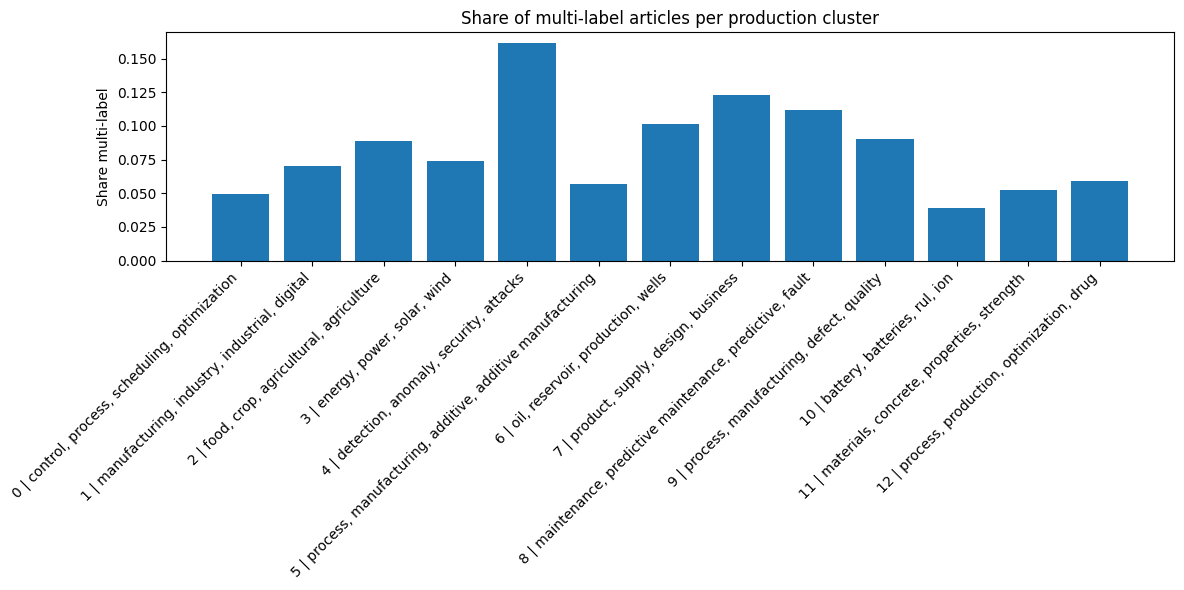

In [100]:
plot_df = share_multi_by_prod.copy()
plot_df["prod_label"] = plot_df[PROD_CAT_COL].map(prod_label_map)

plt.figure(figsize=(12, 6))
plt.bar(plot_df["prod_label"], plot_df["share_multi"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Share multi-label")
plt.title("Share of multi-label articles per production cluster")
plt.tight_layout()
plt.show()


In [58]:
ml_axis_long = df_ml_flags.melt(
    id_vars=[ID_COL, "is_multi"],
    value_vars=ml_flag_cols,
    var_name="ml_axis",
    value_name="is_active"
)

ml_axis_long = ml_axis_long[ml_axis_long["is_active"] == 1].copy()

ml_axis_long["ml_axis"] = ml_axis_long["ml_axis"].map({
    "pred_is_supervised": "supervised",
    "pred_is_unsupervised": "unsupervised",
    "pred_is_reinforcement": "reinforcement"
})

share_multi_by_axis = (
    ml_axis_long
    .groupby("ml_axis")["is_multi"]
    .mean()
    .reset_index(name="share_multi")
)

share_multi_by_axis


,ml_axis,share_multi
0,reinforcement,0.115683
1,supervised,0.125391
2,unsupervised,0.318917


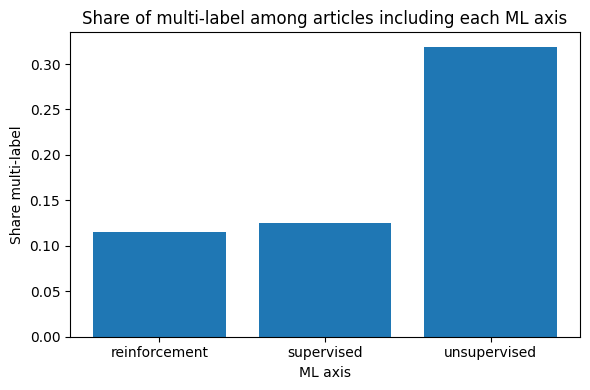

In [59]:
# Bar plot: share of multi-label among articles that include each axis

plt.figure(figsize=(6, 4))
plt.bar(share_multi_by_axis["ml_axis"], share_multi_by_axis["share_multi"])
plt.ylabel("Share multi-label")
plt.xlabel("ML axis")
plt.title("Share of multi-label among articles including each ML axis")
plt.tight_layout()
plt.show()


In [60]:
# Keep only multi-label (>=2)
df_ml_flags = df_ml_flags[df_ml_flags["n_active"] >= 2].copy()

def make_combo(row):
    parts = []
    if row["pred_is_supervised"] == 1:
        parts.append("supervised")
    if row["pred_is_unsupervised"] == 1:
        parts.append("unsupervised")
    if row["pred_is_reinforcement"] == 1:
        parts.append("reinforcement")
    return "+".join(parts)

df_ml_flags["ml_combo"] = df_ml_flags.apply(make_combo, axis=1)


df_combo_prod = df_ml_flags.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

combo_by_prod = (
    df_combo_prod
    .groupby([PROD_CAT_COL, "ml_combo"])[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
    .sort_values(["prod_category", "n_articles"], ascending=[True, False])
)

top3_combo_prod = (
    combo_by_prod
    .sort_values("n_articles", ascending=False)
    .head(3)
)

top3_combo_prod



,prod_category,ml_combo,n_articles
32,8.0,supervised+unsupervised,327
17,4.0,supervised+unsupervised,174
36,9.0,supervised+unsupervised,145


In [61]:
df_ml_flags_all = df_ml_category[[ID_COL] + ml_flag_cols].copy()
df_ml_flags_all["n_active"] = df_ml_flags_all[ml_flag_cols].sum(axis=1)

# Separate none vs labeled
none_df = df_ml_flags_all[df_ml_flags_all["n_active"] == 0].copy()
labeled_df = df_ml_flags_all[df_ml_flags_all["n_active"] > 0].copy()

print("Total none:", len(none_df))
print("Total labeled:", len(labeled_df))


Total none: 1846
Total labeled: 30868


In [62]:
# Count how many total articles per production cluster
total_per_cluster = (
    df_prod_long[PROD_CAT_COL]
    .value_counts()
    .sort_index()
    .rename("total_cluster")
)

# Count none-articles per cluster
none_prod = none_df.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

none_per_cluster = (
    none_prod[PROD_CAT_COL]
    .value_counts()
    .sort_index()
    .rename("none_count")
)

# Combine counts
none_stats = (
    pd.concat([none_per_cluster, total_per_cluster], axis=1)
    .fillna(0)
)

# Compute share
none_stats["none_share"] = none_stats["none_count"] / none_stats["total_cluster"]

# Add readable labels (3 keywords per cluster)
def make_cluster_label(cid):
    words = prod_cluster_keywords.get(str(cid), [])[:3]
    if words:
        return f"{cid} | " + ", ".join(words)
    return str(cid)

none_stats["cluster_label"] = [
    make_cluster_label(cid) for cid in none_stats.index
]

# Reorder columns
none_stats = none_stats[
    ["cluster_label", "none_count", "total_cluster", "none_share"]
]

none_stats


,cluster_label,none_count,total_cluster,none_share
prod_category,,,,
0,"0 | control, process, scheduling",118,2341,0.050406
1,"1 | manufacturing, industry, industrial",247,3423,0.072159
2,"2 | food, crop, agricultural",79,2230,0.035426
3,"3 | energy, power, solar",51,1839,0.027732
4,"4 | detection, anomaly, security",86,2277,0.037769
5,"5 | process, manufacturing, additive",207,3783,0.054718
6,"6 | oil, reservoir, production",73,1516,0.048153
7,"7 | product, supply, design",337,3349,0.100627
8,"8 | maintenance, predictive maintenance, predi...",202,4103,0.049232


In [63]:
# Prepare method lists
df_methods = df_ml_methods[[ID_COL, "ml_methods_list"]].copy()
df_methods["n_methods"] = df_methods["ml_methods_list"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Merge into none vs labeled
none_methods = none_df.merge(df_methods, on=ID_COL, how="left")
labeled_methods = labeled_df.merge(df_methods, on=ID_COL, how="left")

print("Avg methods (none):", none_methods["n_methods"].mean())
print("Avg methods (labeled):", labeled_methods["n_methods"].mean())

print("\nMedian methods (none):", none_methods["n_methods"].median())
print("Median methods (labeled):", labeled_methods["n_methods"].median())

# Share with zero methods
none_zero_share = (none_methods["n_methods"] == 0).mean()
labeled_zero_share = (labeled_methods["n_methods"] == 0).mean()

print("\nShare with zero methods (none):", none_zero_share)
print("Share with zero methods (labeled):", labeled_zero_share)


Avg methods (none): 0.2399783315276273
Avg methods (labeled): 0.9322923415835169

Median methods (none): 0.0
Median methods (labeled): 0.0

Share with zero methods (none): 0.8087757313109426
Share with zero methods (labeled): 0.554684462874174
